<h2>Setup Environment</h2>

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, brier_score_loss, log_loss, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay 
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
import lightgbm as lgb
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
import re
import nfl_data_py as nfl

import warnings
warnings.filterwarnings("ignore")

<h2>Load Data</h2>

In [2]:
years = [2024]
play_by_play = nfl.import_pbp_data(years, downcast=True, cache=False)

2024 done.
Downcasting floats.


<h2>Feature Engineering</h2>
<ol>
    <li>Filter out unnecessary text, IDs, and meaningless fields</li>
    <li>Build the next play label</li>
    <li>Build the next posession team label. We want to make sure the row captures who has the ball next.</li>
</ol>

In [3]:
# Drop columns that are IDs, free text, or meaningless at decision time
def prepare_next_play_dataset(
    df: pd.DataFrame,
    id_and_text_drop=None,
    run_labels=("run", "rush"),   # handle naming differences
    pass_labels=("pass",),
    game_sort_cols=("game_id", "game_seconds_remaining", "play_id")
):
    """
    Build a leakage-safe dataset for predicting the *next* play (pass/run) by the *same offense*.
    Returns: X (features), y (0=run,1=pass), groups (game_id), base_df (cleaned working frame)
    """

    # Sort plays within games (descending clock; play_id ensures tie-break)
    sort_cols = list(game_sort_cols)
    ascending = [True] + [False] * (len(sort_cols) - 1)  # game_id asc, then desc for the rest
    df = df.sort_values(sort_cols, ascending=ascending).copy()

    # Build next-play fields within each game
    g = df.groupby("game_id", sort=False)

    # Who has the ball next?
    df["next_posteam"] = g["posteam"].shift(-1)
    next_playtype_col = (
        g["play_type_simple"].shift(-1)
        if "play_type_simple" in df.columns
        else g["play_type"].shift(-1)
    )
    df["next_playtype"] = next_playtype_col.astype(str).str.lower()

    # Keep only rows where the same team will snap the next play
    same_team_mask = (df["next_posteam"] == df["posteam"])

    # Keep only rows where the next play is a pure run or pass
    run_set  = set(s.lower() for s in run_labels)
    pass_set = set(s.lower() for s in pass_labels)
    next_is_run  = df["next_playtype"].isin(run_set)
    next_is_pass = df["next_playtype"].isin(pass_set)

    keep_mask = same_team_mask & (next_is_run | next_is_pass)

    work = df.loc[keep_mask].copy()

    # Create the binary label for the next play
    work["target_pass_next"] = (work["next_playtype"].isin(pass_set)).astype(int)

    # Drop obvious leakage/noise: IDs, free text, timestamps that uniquely ID a play, etc.
    default_id_and_text_drop = [
        # free text / near-unique
        "desc",
        # pure identifiers / hashes
        "old_game_id", "play_id",
        # raw time strings
        "drive_real_start_time", "drive_game_clock_start", "drive_game_clock_end",
        # duplicative drive boundary IDs
        "drive_play_id_started", "drive_play_id_ended",
    ]
    if id_and_text_drop is None:
        id_and_text_drop = default_id_and_text_drop
    to_drop = [c for c in id_and_text_drop if c in work.columns]
    if to_drop:
        work = work.drop(columns=to_drop)

    # Keep game_id for grouping, but exclude it from X later
    groups = work["game_id"].copy()

    # Remove helper/label columns from features
    helper_cols = ["next_posteam", "next_playtype", "target_pass_next"]
    feature_cols = [c for c in work.columns if c not in (helper_cols + ["game_id"])]

    # Cast object→category to help LightGBM
    obj_cols = [c for c in feature_cols if work[c].dtype == "object"]
    for c in obj_cols:
        work[c] = work[c].astype("category")

    X = work[feature_cols]
    y = work["target_pass_next"].astype(int)

    return X, y, groups, work

<p>Add features that an offensive coordinator would think about when calling the next play</p>
<ol>
    <li>What is the next down?</li>
    <li>How many yards between the line of scrimmage and the marker?</li>
    <li>What part of the field am I in?</li>
    <li>Are we trailing or winning?</li>
    <li>What is the clock situation?</li>
</ol>

In [4]:
def add_next_state_features(work: pd.DataFrame) -> pd.DataFrame:
    g = work.groupby("game_id", sort=False)
    for col in ["down","ydstogo","yardline_100","score_differential","wp"]:
        work[f"next_{col}"] = g[col].shift(-1)

    work["next_down_cat"] = work["next_down"].astype("Int64")
    work["next_yds_bin"] = pd.cut(work["next_ydstogo"],
                                  bins=[-1,1,3,6,10,15,99],
                                  labels=["1","2-3","4-6","7-10","11-15","16+"])
    work["next_field_zone"] = pd.cut(work["next_yardline_100"],
                                     bins=[-1,20,50,80,100],
                                     labels=["backed_up","own_half","opp_half","redzone"])
    work["next_score_bucket"] = pd.cut(work["next_score_differential"],
                                       bins=[-99,-7,7,99],
                                       labels=["trailing","close","ahead"])
    work["clock_bucket"] = pd.cut(work["game_seconds_remaining"].fillna(-1),
                                  bins=[-1,120,240,600,1800,3600],
                                  labels=["2min","2-4min","4-10min","10-30min","early"])
    for c in ["next_down_cat","next_yds_bin","next_field_zone","next_score_bucket","clock_bucket"]:
        work[c] = work[c].astype("category")
    return work

<p>A game plan designed before kickoff may not be working during the game. Does the success of previous plays in the game factor into the decision making?</p>

In [5]:
def add_short_term_history_features(work: pd.DataFrame) -> pd.DataFrame:
    """
    Leakage-safe short-term history features.
    Assumes columns: game_id, posteam, play_type_simple (or play_type),
                     success, epa, yards_gained, game_seconds_remaining,
                     optional: drive, penalty, penalty_yards, sack, shotgun, no_huddle.
    """
    work = work.copy()

    # --- normalize current play type ---
    if "play_type_simple" in work.columns:
        cur_type = work["play_type_simple"].astype(str).str.lower()
    else:
        cur_type = work.get("play_type", pd.Series(index=work.index, dtype="object")).astype(str).str.lower()

    work["is_pass_now"] = (cur_type == "pass").astype(int)
    work["is_run_now"]  = (cur_type.isin(["run", "rush"])).astype(int)

    # group helpers
    g_team_game = work.groupby(["game_id", "posteam"], sort=False)

    # recent pass-rate windows (team within game)
    for w in (3, 5, 10):
        work[f"team_pass_rate_w{w}"] = g_team_game["is_pass_now"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )

    # drive-scoped pass-rate windows (use transform to keep index flat)
    if "drive" in work.columns:
        g_tg_drive = work.groupby(["game_id", "posteam", "drive"], sort=False)
        for w in (3, 5, 10):
            work[f"drive_pass_rate_w{w}"] = g_tg_drive["is_pass_now"].transform(
                lambda s: s.shift(1).rolling(w, min_periods=1).mean()
            )

    # streaks entering the row (consecutive same-type BEFORE this play)
    def _prior_streak(series: pd.Series) -> pd.Series:
        out = np.zeros(len(series), dtype=int)
        prev = None
        count = 0
        vals = series.to_numpy()
        for i, v in enumerate(vals):
            if prev is None or v != prev:
                count = 0
            else:
                count += 1
            out[i] = count
            prev = v
        return pd.Series(out, index=series.index)

    work["pass_streak"] = g_team_game["is_pass_now"].transform(_prior_streak)
    work["run_streak"]  = g_team_game["is_run_now"].transform(_prior_streak)

    # last play outcomes (carryover)
    work["prev_success"] = g_team_game["success"].shift(1).fillna(0).astype(float)

    work["prev_epa"] = g_team_game["epa"].shift(1).astype(float)
    work["prev_epa_bucket"] = pd.cut(
        work["prev_epa"].fillna(0.0),
        bins=[-10, -2.0, -0.5, 0.0, 0.5, 2.0, 10],
        labels=["catastrophic","bad","minus","neutral","plus","explosive"]
    )

    work["prev_yards"] = g_team_game["yards_gained"].shift(1).astype(float)
    work["prev_yards_bucket"] = pd.cut(
        work["prev_yards"].fillna(0.0),
        bins=[-10, -1, 0, 3, 7, 15, 60],
        labels=["loss","stuffed","no_gain","short","chunk","explosive"]
    )

    # penalties: use explicit flag if present, else proxy from penalty_yards
    if "penalty" in work.columns:
        work["prev_penalty_flag"] = g_team_game["penalty"].shift(1).fillna(0).astype(int)
    else:
        work["penalty_proxy"] = (work.get("penalty_yards", pd.Series(0, index=work.index)).abs() > 0).astype(int)
        work["prev_penalty_flag"] = g_team_game["penalty_proxy"].shift(1).fillna(0).astype(int)

    if "sack" in work.columns:
        work["prev_sack_flag"] = g_team_game["sack"].shift(1).fillna(0).astype(int)

    # tempo / formation carryover
    work["delta_secs_prev"] = (
        g_team_game["game_seconds_remaining"].shift(1) - work["game_seconds_remaining"]
    )

    work["tempo_bucket"] = pd.cut(
        work["delta_secs_prev"].fillna(-1),
        bins=[-1, 10, 20, 35, 60, 120, 10000],
        labels=["hyper","fast","normal","leisurely","slow","stoppage"]
    )

    if "shotgun" in work.columns:
        work["shotgun_prev"] = g_team_game["shotgun"].shift(1).fillna(0).astype(int)
    if "no_huddle" in work.columns:
        work["no_huddle_prev"] = g_team_game["no_huddle"].shift(1).fillna(0).astype(int)

    # keep rates as numeric
    for c in ["prev_epa_bucket", "prev_yards_bucket", "tempo_bucket"]:
        if c in work.columns:
            work[c] = work[c].astype("category")

    return work

<p>Andy Reid is known for being pass heavy. Kyle Shanahan is known for running the ball. Based on coaching tendencies in the past weeks of the season, let's build some features based on coaching and team tendencies.</p>

In [6]:
def add_tendency_features(work: pd.DataFrame, k: float = 100.0, league_p: float = None) -> pd.DataFrame:
    """
    Expanding (leakage-safe) tendencies with Bayesian smoothing.
    Creates coach/team/defense priors overall, by next down, and (coach) by next distance bin.
    Only uses past info: cumulative sums are shifted by 1 (as-of BEFORE current row).
    """
    work = work.copy()

    if "is_pass_now" not in work.columns:
        cur_type = work.get("play_type_simple", work.get("play_type", pd.Series(index=work.index, dtype="object"))).astype(str).str.lower()
        work["is_pass_now"] = (cur_type == "pass").astype(int)

    work["down_cat_now"] = work["down"].astype("Int64")

    # offense coach on this play
    if "off_coach" not in work.columns:
        if {"home_team","away_team","home_coach","away_coach"}.issubset(work.columns):
            work["off_coach"] = np.where(work["posteam"] == work["home_team"], work["home_coach"], work["away_coach"])
        else:
            work["off_coach"] = work.get("coach", pd.Series("UNK", index=work.index))

    # current distance bins
    dist_labels = ["1","2-3","4-6","7-10","11-15","16+"]
    work["yds_bin_now"] = pd.cut(work["ydstogo"], bins=[-1,1,3,6,10,15,99], labels=dist_labels)

    # league prior
    if league_p is None:
        league_p = float(work["is_pass_now"].mean())

    def _smoothed_expanding_for_condition(group_key: pd.Series, cond_bool: pd.Series) -> pd.Series:
        gk = pd.Series(group_key, index=work.index)
        if str(gk.dtype) == "category":
            gk = gk.astype("object")
        gk = gk.where(~gk.isna(), "UNK")

        cb = pd.Series(cond_bool, index=work.index).fillna(False).astype(int)

        inc = cb
        pass_inc = work["is_pass_now"] * inc

        cum_n = inc.groupby(gk).cumsum()
        cum_p = pass_inc.groupby(gk).cumsum()

        cum_n_prev = cum_n.groupby(gk).shift(1).fillna(0.0)
        cum_p_prev = cum_p.groupby(gk).shift(1).fillna(0.0)

        num = k * league_p + cum_p_prev
        den = k + cum_n_prev
        return num / den

    # Coach: overall tendency
    work["coach_pass_rate_overall"] = _smoothed_expanding_for_condition(
        group_key=work["off_coach"],
        cond_bool=pd.Series(True, index=work.index)
    )

    # Coach: by NEXT down
    for d in (1,2,3,4):
        work[f"coach_pass_rate_down{d}_asof"] = _smoothed_expanding_for_condition(
            group_key=work["off_coach"],
            cond_bool=work["down_cat_now"].eq(d)
        )

    def _pick_by_next_down(row, prefix):
        nd = row.get("next_down")
        if pd.isna(nd):
            return np.nan
        d = int(nd)
        return row.get(f"{prefix}{d}_asof", np.nan)

    work["coach_down_pass_rate_next"] = work.apply(
        lambda r: _pick_by_next_down(r, "coach_pass_rate_down"), axis=1
    )

    # Coach: by NEXT distance bin
    for lab in dist_labels:
        work[f"coach_pass_rate_dist_{lab}_asof"] = _smoothed_expanding_for_condition(
            group_key=work["off_coach"],
            cond_bool=work["yds_bin_now"].astype(str).eq(str(lab))
        )

    def _pick_by_next_dist(row):
        lab = row.get("next_yds_bin")
        if pd.isna(lab):
            return np.nan
        return row.get(f"coach_pass_rate_dist_{str(lab)}_asof", np.nan)

    work["coach_dist_pass_rate_next"] = work.apply(_pick_by_next_dist, axis=1)

    # Team: overall + by NEXT down
    work["team_pass_rate_overall"] = _smoothed_expanding_for_condition(
        group_key=work["posteam"],
        cond_bool=pd.Series(True, index=work.index)
    )
    for d in (1,2,3,4):
        work[f"team_pass_rate_down{d}_asof"] = _smoothed_expanding_for_condition(
            group_key=work["posteam"],
            cond_bool=work["down_cat_now"].eq(d)
        )
    work["team_down_pass_rate_next"] = work.apply(
        lambda r: _pick_by_next_down(r, "team_pass_rate_down"), axis=1
    )

    # Defense: overall + by NEXT down
    work["def_pass_allowed_overall"] = _smoothed_expanding_for_condition(
        group_key=work["defteam"],
        cond_bool=pd.Series(True, index=work.index)
    )
    for d in (1,2,3,4):
        work[f"def_pass_allowed_down{d}_asof"] = _smoothed_expanding_for_condition(
            group_key=work["defteam"],
            cond_bool=work["down_cat_now"].eq(d)
        )
    work["def_down_pass_allowed_next"] = work.apply(
        lambda r: _pick_by_next_down(r, "def_pass_allowed_down"), axis=1
    )

    return work

<p>The weather plays a huge part in decision making. When it's snowing, teams are more likely to run. When the game is being played indoors and wind is not a factor, teams tend to pass more.</p>

In [7]:
def add_environment_features(work: pd.DataFrame) -> pd.DataFrame:
    """
    Environment + context features known before the next snap:
      - Roof (indoor/outdoor), surface (grass/turf), temp & wind (cleaned + bins), precip flags
      - Offense home/away on NEXT snap
      - NEXT snap timeouts remaining for offense (and bucket)
      - NEXT snap two-minute situation flags (by quarter / by half if available)
    Assumes columns may include:
      roof, surface, temp, wind, weather, humidity,
      game_id, qtr, game_seconds_remaining, half_seconds_remaining,
      home_team, away_team, posteam, next_posteam,
      home_timeouts_remaining, away_timeouts_remaining
    Works gracefully if some columns are missing.
    """
    work = work.copy()

    def _norm_roof(s: pd.Series) -> pd.Series:
        x = s.astype(str).str.lower()
        x = x.replace({
            "na": np.nan, "nan": np.nan, "none": np.nan,
            "retractable": "closed", "open": "outdoors"
        })
        cat = pd.Series(np.where(x.isin(["dome","closed"]), "indoor",
                         np.where(x.isin(["outdoor","outdoors"]), "outdoor", "unknown")),
                        index=s.index)
        return cat.astype("category")

    def _norm_surface(s: pd.Series) -> pd.Series:
        x = s.astype(str).str.lower()
        x = x.replace({"artificial": "turf", "fieldturf": "turf", "astroplay": "turf"})
        cat = pd.Series(np.where(x.str.contains("turf|artificial|astro", na=False), "turf",
                         np.where(x.str.contains("grass|natural", na=False), "grass", "unknown")),
                        index=s.index)
        return cat.astype("category")

    if "roof" in work.columns:
        work["roof_norm"] = _norm_roof(work["roof"])
        work["is_indoor"] = (work["roof_norm"] == "indoor").astype(int)

    if "surface" in work.columns:
        work["surface_norm"] = _norm_surface(work["surface"])

    # Clean temp / wind / humidity & make bins
    def _to_float(series: pd.Series) -> pd.Series:
        s = series.copy()
        if pd.api.types.is_numeric_dtype(s):
            return pd.to_numeric(s, errors="coerce")
        # extract first float in the string
        num = s.astype(str).str.extract(r"([-+]?\d*\.?\d+)")[0]
        return pd.to_numeric(num, errors="coerce")

    if "temp" in work.columns:
        work["temp_f"] = _to_float(work["temp"])
        work["temp_bin"] = pd.cut(
            work["temp_f"],
            bins=[-50, 32, 50, 70, 85, 150],
            labels=["freezing","cool","mild","warm","hot"]
        ).astype("category")

    if "wind" in work.columns:
        work["wind_mph"] = _to_float(work["wind"])
        work["wind_bin"] = pd.cut(
            work["wind_mph"],
            bins=[-1, 5, 15, 50],
            labels=["calm","breezy","windy"]
        ).astype("category")
        work["is_windy"] = (work["wind_mph"] >= 15).astype(int)

    if "humidity" in work.columns:
        work["humidity_pct"] = _to_float(work["humidity"])
        work["humidity_bin"] = pd.cut(
            work["humidity_pct"], bins=[-1, 40, 60, 100], labels=["dry","normal","humid"]
        ).astype("category")

    # precipitation flags from free-text weather, if present
    if "weather" in work.columns:
        wtxt = work["weather"].astype(str).str.lower()
        work["precip_flag"] = wtxt.str.contains(
            r"rain|drizzle|shower|storm|thunder|hail|sleet", regex=True, na=False
        ).astype(int)
        work["snow_flag"] = wtxt.str.contains(r"snow|flurr", regex=True, na=False).astype(int)
        work["fog_flag"]  = wtxt.str.contains(r"fog", regex=True, na=False).astype(int)

    # If indoor, wind doesn't affect ball flight; keep both raw & interaction if you like
    if "is_indoor" in work.columns and "is_windy" in work.columns:
        work["windy_outdoor"] = ((work["is_indoor"] == 0) & (work["is_windy"] == 1)).astype(int)

    # NEXT-snap timeouts & home/away for offense
    g = work.groupby("game_id", sort=False)

    # next_qtr / next_game_seconds for two-minute logic
    if "qtr" in work.columns:
        work["next_qtr"] = g["qtr"].shift(-1)
    if "game_seconds_remaining" in work.columns:
        work["next_game_seconds_remaining"] = g["game_seconds_remaining"].shift(-1)
    if "half_seconds_remaining" in work.columns:
        work["next_half_seconds_remaining"] = g["half_seconds_remaining"].shift(-1)

    # Who is on offense next?
    if "next_posteam" not in work.columns:
        work["next_posteam"] = g["posteam"].shift(-1)

    # Is that offense the home team on next snap?
    if {"home_team","away_team"}.issubset(work.columns):
        work["is_home_offense_next"] = np.where(
            work["next_posteam"] == work["home_team"], 1,
            np.where(work["next_posteam"] == work["away_team"], 0, np.nan))

    # Next-snap timeouts for the offense
    if {"home_timeouts_remaining","away_timeouts_remaining","home_team","away_team"}.issubset(work.columns):
        next_home_to = g["home_timeouts_remaining"].shift(-1)
        next_away_to = g["away_timeouts_remaining"].shift(-1)
        work["next_off_timeouts"] = np.where(
            work["next_posteam"] == work["home_team"], next_home_to,
            np.where(work["next_posteam"] == work["away_team"], next_away_to, np.nan)
        )
        work["next_off_timeouts_bucket"] = pd.Categorical(
            pd.cut(work["next_off_timeouts"], bins=[-1,0,1,2,3], labels=["0","1","2","3"])
        )

    # Two-minute situation on NEXT snap by quarter: final 2:00 of Q2 and Q4
    if {"next_qtr","next_game_seconds_remaining"}.issubset(work.columns):
        # seconds remaining in quarter isn’t directly present; approximate via mod 900 if needed.
        # When only game_seconds_remaining exists, a simple and still useful flag is:
        # - Q2: GSR in (1800..3600] → two-minute when GSR % 1800 <= 120
        # - Q4: GSR in (0..1800]    → two-minute when GSR % 1800 <= 120
        gsr = work["next_game_seconds_remaining"]
        nq = work["next_qtr"]
        # modulo within half (each half is 1800s)
        within_half = (gsr % 1800).astype(float)
        work["two_minute_next_qtr"] = (
            (nq.isin([2,4])) & (within_half <= 120)
        ).astype(int)

    # by half if we have it precisely
    if "next_half_seconds_remaining" in work.columns:
        work["two_minute_next_half"] = (work["next_half_seconds_remaining"] <= 120).astype(int)

    # Cast buckets to category
    for c in ["temp_bin","wind_bin","humidity_bin","next_off_timeouts_bucket"]:
        if c in work.columns:
            work[c] = work[c].astype("category")

    # Keep raw numerics for models that benefit from continuous inputs
    return work

In [8]:
def select_features_for_model(
    work: pd.DataFrame,
    target_col: str = "target_pass_next",
    drop_raw_team_ids: bool = True,
    missing_frac_thresh: float = 0.98,   # drop if >= 98% missing
    high_card_thresh: int = 200,         # drop object/cat with >200 unique values
    low_var_thresh: float = 1e-9         # drop numeric with ~zero variance
):
    """
    Prune unhelpful columns and return X, y, feature_cols, and a summary dict.
    Assumes `work` already contains Steps 0-4 features.
    """
    df = work.copy()

    # 1) Always-drop helpers/labels/IDs/free text
    always_drop = set([
        target_col, "game_id", "next_playtype", "next_posteam",  # helpers/label bits
        "old_game_id", "play_id", "desc",                        # IDs/text
        "drive_real_start_time","drive_game_clock_start","drive_game_clock_end",
        "drive_play_id_started","drive_play_id_ended",
        "game_date","game_clock","play_clock"  # if present as strings
    ]) & set(df.columns)

    # 2) Optional: drop raw team/coach IDs (we have smoothed tendencies already)
    raw_ids = set([
        "posteam","defteam","home_team","away_team",
        "home_coach","away_coach","off_coach"
    ]) & set(df.columns)
    if drop_raw_team_ids:
        always_drop |= raw_ids

    # 3) Leakage guard: drop any accidental "next_*" that isn’t on our whitelist
    next_whitelist = {
        "next_down","next_ydstogo","next_yardline_100","next_score_differential","next_wp",
        "next_down_cat","next_yds_bin","next_field_zone","next_score_bucket",
        "next_qtr","next_game_seconds_remaining","next_half_seconds_remaining",
        "next_off_timeouts","next_off_timeouts_bucket"
    }
    next_cols = {c for c in df.columns if c.startswith("next_")}
    leak_next = next_cols - next_whitelist
    always_drop |= leak_next

    # 4) High-missing columns
    missing_frac = df.isna().mean()
    drop_missing = set(missing_frac[missing_frac >= missing_frac_thresh].index)

    # 5) Low-variance numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    near_const = set()
    for c in num_cols:
        s = df[c]
        # treat NaNs as ignorable; check variance on non-nans
        vals = s.dropna()
        if vals.empty or vals.nunique() <= 1 or float(vals.var()) <= low_var_thresh:
            near_const.add(c)

    # 6) High-cardinality object/categorical columns (whitelist engineered buckets)
    whitelist_smallcats = {
        "next_down_cat","next_yds_bin","next_field_zone","next_score_bucket","clock_bucket",
        "prev_epa_bucket","prev_yards_bucket","tempo_bucket",
        "temp_bin","wind_bin","humidity_bin",
        "roof_norm","surface_norm","is_indoor","is_windy","windy_outdoor",
        "is_home_offense_next","next_off_timeouts_bucket"
    }
    obj_cat_cols = df.select_dtypes(include=["object","category"]).columns
    high_card = set()
    for c in obj_cat_cols:
        if c in whitelist_smallcats:
            continue
        nunq = df[c].nunique(dropna=True)
        if nunq > high_card_thresh:
            high_card.add(c)

    # 7) Build final drop set
    drop_cols = (always_drop | drop_missing | near_const | high_card) & set(df.columns)

    # 8) Final feature list
    feature_cols = [c for c in df.columns if c not in drop_cols]

    # LightGBM likes categories; ensure category dtype for our bucket cols
    cat_cols = df[feature_cols].select_dtypes(include="object").columns
    for c in cat_cols:
        df[c] = df[c].astype("category")

    X = df[feature_cols]
    y = df[target_col].astype(int)

    summary = {
        "dropped_total": len(drop_cols),
        "dropped_helpers": sorted(always_drop & set(df.columns)),
        "dropped_missing": sorted(drop_missing),
        "dropped_low_variance": sorted(near_const),
        "dropped_high_cardinality": sorted(high_card),
        "n_features_final": len(feature_cols)
    }
    return X, y, feature_cols, summary

In [9]:
# Step 1
X0, y0, groups0, work = prepare_next_play_dataset(play_by_play)   # df = your play-by-play DataFrame

# Step 2
work = add_next_state_features(work)

# Step 3
work = add_short_term_history_features(work)

# Step 4
work = add_tendency_features(work, k=100.0)

# Step 5
work = add_environment_features(work)

# Step 6
X_all, y_all, feature_cols, drop_summary = select_features_for_model(
    work,
    drop_raw_team_ids=True,
    missing_frac_thresh=0.98,
    high_card_thresh=200,
    low_var_thresh=1e-9
)

print("Dropped", drop_summary["dropped_total"], "columns. Final feature count:", drop_summary["n_features_final"])

Dropped 149 columns. Final feature count: 297


<h2>Model Building</h2>

In [10]:
def group_train_val_test_split(groups: pd.Series, test_size=0.2, val_size=0.2, random_state=42):
    """
    Group (by game_id) split into train/val/test without leakage.
    Returns: (train_idx, val_idx, test_idx)
    """
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    # First split off test
    all_idx = np.arange(len(groups))
    trainval_idx, test_idx = next(gss.split(all_idx, groups=groups))

    # Now split train/val within the remaining pool
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_idx, val_idx = next(gss_inner.split(trainval_idx, groups=groups.iloc[trainval_idx]))

    # Map inner indices back to absolute indices
    train_idx = trainval_idx[train_idx]
    val_idx   = trainval_idx[val_idx]

    return train_idx, val_idx, test_idx

In [11]:
groups = work.loc[X_all.index, "game_id"]
train_idx, val_idx, test_idx = group_train_val_test_split(groups, test_size=0.2, val_size=0.2, random_state=42)

X_train_raw, y_train = X_all.iloc[train_idx].copy(), y_all.iloc[train_idx].copy()
X_val_raw,   y_val   = X_all.iloc[val_idx].copy(),   y_all.iloc[val_idx].copy()
X_test_raw,  y_test  = X_all.iloc[test_idx].copy(),  y_all.iloc[test_idx].copy()

for df_split in (X_train_raw, X_val_raw, X_test_raw):
    obj_cols = df_split.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        df_split[c] = df_split[c].astype("category")

categorical_cols = list(X_train_raw.select_dtypes(include=["category"]).columns)

for c in categorical_cols:
    cats = (
        X_train_raw[c].astype("category").cat.categories
        .union(X_val_raw[c].astype("category").cat.categories)
        .union(X_test_raw[c].astype("category").cat.categories)
    )
    X_train_raw[c] = X_train_raw[c].astype("category").cat.set_categories(cats)
    X_val_raw[c]   = X_val_raw[c].astype("category").cat.set_categories(cats)
    X_test_raw[c]  = X_test_raw[c].astype("category").cat.set_categories(cats)

clf = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

clf.fit(
    X_train_raw, y_train,
    eval_set=[(X_val_raw, y_val)],
    eval_metric="logloss",
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(100), log_evaluation(50)]
)

best_iter = clf.best_iteration_
print("Best iteration:", best_iter)

def evaluate_split(name, X, y, model, thr=0.5):
    proba = model.predict_proba(X, num_iteration=best_iter)[:, 1]
    pred  = (proba >= thr).astype(int)
    acc   = accuracy_score(y, pred)
    ll    = log_loss(y, proba, labels=[0,1])
    auc   = roc_auc_score(y, proba)
    brier = brier_score_loss(y, proba)
    cm    = confusion_matrix(y, pred, labels=[0,1])
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | LogLoss: {ll:.4f} | AUC: {auc:.4f} | Brier: {brier:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    return proba, pred

_ = evaluate_split("Validation", X_val_raw,  y_val,  clf)
_ = evaluate_split("Test",        X_test_raw, y_test, clf)

print("\nClassification report (Test):")
print(classification_report(y_test, (clf.predict_proba(X_test_raw, num_iteration=best_iter)[:,1] >= 0.5).astype(int)))

# Feature importance (top 30)
import pandas as pd
gain_imp  = pd.Series(clf.booster_.feature_importance(importance_type="gain"),  index=X_train_raw.columns).sort_values(ascending=False)
split_imp = pd.Series(clf.booster_.feature_importance(importance_type="split"), index=X_train_raw.columns).sort_values(ascending=False)

print("\nTop features by GAIN:\n",  gain_imp.head(30))
print("\nTop features by SPLIT:\n", split_imp.head(30))

[LightGBM] [Info] Number of positive: 10045, number of negative: 7118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27879
[LightGBM] [Info] Number of data points in the train set: 17163, number of used features: 294
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585271 -> initscore=0.344448
[LightGBM] [Info] Start training from score 0.344448
Training until validation scores don't improve for 100 rounds


[50]	valid_0's binary_logloss: 0.57353


[100]	valid_0's binary_logloss: 0.566338
[150]	valid_0's binary_logloss: 0.565212


[200]	valid_0's binary_logloss: 0.565352
[250]	valid_0's binary_logloss: 0.567273


Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.565107
Best iteration: 166

=== Validation ===
Accuracy: 0.7085 | LogLoss: 0.5651 | AUC: 0.7677 | Brier: 0.1915
Confusion matrix [[TN FP],[FN TP]]:
 [[1123  664]
 [ 596 1939]]

=== Test ===
Accuracy: 0.7006 | LogLoss: 0.5659 | AUC: 0.7635 | Brier: 0.1923
Confusion matrix [[TN FP],[FN TP]]:
 [[1335  853]
 [ 768 2458]]

Classification report (Test):
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2188
           1       0.74      0.76      0.75      3226

    accuracy                           0.70      5414
   macro avg       0.69      0.69      0.69      5414
weighted avg       0.70      0.70      0.70      5414


Top features by GAIN:
 epa                            13974.743148
xpass                           7272.291310
side_of_field                   4948.932336
stadium                         3615.663774
next_ydstogo                    3019.286475
passer    

<h2>Fix Overfitting</h2>
<p>We might be overfitting. The accuracy is around 70%, but we can improve that.</p>

In [12]:
# Recompute groups aligned to X_all (from select_features_for_model)
groups = work.loc[X_all.index, "game_id"]

# cast object->category and align categories across splits
def prepare_cats(Xtr, Xva, Xte):
    for df_split in (Xtr, Xva, Xte):
        obj_cols = df_split.select_dtypes(include=["object"]).columns
        for c in obj_cols:
            df_split[c] = df_split[c].astype("category")
    categorical_cols = list(Xtr.select_dtypes(include=["category"]).columns)
    for c in categorical_cols:
        cats = (
            Xtr[c].cat.categories
            .union(Xva[c].cat.categories)
            .union(Xte[c].cat.categories)
        )
        Xtr[c] = Xtr[c].cat.set_categories(cats)
        Xva[c] = Xva[c].cat.set_categories(cats)
        Xte[c] = Xte[c].cat.set_categories(cats)
    return categorical_cols

# find best threshold on validation for accuracy
def best_threshold(y_true, proba):
    thr_grid = np.linspace(0.3, 0.7, 81)
    accs = [(thr, accuracy_score(y_true, (proba >= thr).astype(int))) for thr in thr_grid]
    thr, acc = max(accs, key=lambda t: t[1])
    return thr, acc

def train_eval_variant(name, keep_cols):
    train_idx, val_idx, test_idx = group_train_val_test_split(groups, test_size=0.2, val_size=0.2, random_state=42)

    Xtr_raw, ytr = X_all.loc[X_all.index[train_idx], keep_cols].copy(), y_all.iloc[train_idx].copy()
    Xva_raw, yva = X_all.loc[X_all.index[val_idx],   keep_cols].copy(), y_all.iloc[val_idx].copy()
    Xte_raw, yte = X_all.loc[X_all.index[test_idx],  keep_cols].copy(), y_all.iloc[test_idx].copy()

    categorical_cols = prepare_cats(Xtr_raw, Xva_raw, Xte_raw)

    clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(
        Xtr_raw, ytr,
        eval_set=[(Xva_raw, yva)],
        eval_metric="logloss",
        categorical_feature=categorical_cols,
        callbacks=[early_stopping(100), log_evaluation(50)]
    )

    best_iter = clf.best_iteration_
    proba_val = clf.predict_proba(Xva_raw, num_iteration=best_iter)[:,1]
    thr, _ = best_threshold(yva, proba_val)

    def report(split, X, y):
        p = clf.predict_proba(X, num_iteration=best_iter)[:,1]
        preds = (p >= thr).astype(int)
        metrics = {
            "thr": thr,
            "acc": accuracy_score(y, preds),
            "logloss": log_loss(y, p, labels=[0,1]),
            "auc": roc_auc_score(y, p),
            "brier": brier_score_loss(y, p),
        }
        return metrics

    val_metrics  = report("val",  Xva_raw, yva)
    test_metrics = report("test", Xte_raw, yte)

    print(f"\n=== {name} ===")
    print(f"Val:  acc {val_metrics['acc']:.4f} | logloss {val_metrics['logloss']:.4f} | AUC {val_metrics['auc']:.4f} | Brier {val_metrics['brier']:.4f} | thr {val_metrics['thr']:.3f}")
    print(f"Test: acc {test_metrics['acc']:.4f} | logloss {test_metrics['logloss']:.4f} | AUC {test_metrics['auc']:.4f} | Brier {test_metrics['brier']:.4f} | thr {val_metrics['thr']:.3f}")

    return {
        "model": clf, "best_iter": best_iter, "thr": thr,
        "val": val_metrics, "test": test_metrics,
        "keep_cols": keep_cols
    }

all_cols = list(X_all.columns)

# regex for player/crew identifiers we want to drop
player_regex = re.compile(
    r"(passer|rusher|receiver|tackle|assist_tackle|qb_hit|sack_player|"
    r"pass_defense|intercept|lateral|fumble|penalty_player|player_id|player_name)",
    flags=re.I
)

# baseline: keep everything you selected in Step 5
variants = {"baseline": all_cols}

# drop player/crew identity columns + stadium (overfit/venue proxy)
no_players_stadium = [c for c in all_cols if (not player_regex.search(c)) and c not in {"stadium"}]
variants["no_players_stadium"] = no_players_stadium

# also drop current-play priors (xpass / pass_oe)
no_players_stadium_no_xpass = [c for c in no_players_stadium if c not in {"xpass","pass_oe"}]
variants["no_players_stadium_no_xpass"] = no_players_stadium_no_xpass

results = {}
for name, cols in variants.items():
    results[name] = train_eval_variant(name, cols)

# inspect which variant wins on validation accuracy/AUC etc.
best = max(results.items(), key=lambda kv: kv[1]["val"]["auc"])
print("\nBest by Val AUC:", best[0], best[1]["val"])

[LightGBM] [Info] Number of positive: 10045, number of negative: 7118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27879
[LightGBM] [Info] Number of data points in the train set: 17163, number of used features: 294
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585271 -> initscore=0.344448
[LightGBM] [Info] Start training from score 0.344448
Training until validation scores don't improve for 100 rounds


[50]	valid_0's binary_logloss: 0.57353


[100]	valid_0's binary_logloss: 0.566338
[150]	valid_0's binary_logloss: 0.565212


[200]	valid_0's binary_logloss: 0.565352
[250]	valid_0's binary_logloss: 0.567273


Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.565107

=== baseline ===
Val:  acc 0.7103 | logloss 0.5651 | AUC 0.7677 | Brier 0.1915 | thr 0.480
Test: acc 0.6971 | logloss 0.5659 | AUC 0.7635 | Brier 0.1923 | thr 0.480


[LightGBM] [Info] Number of positive: 10045, number of negative: 7118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27187
[LightGBM] [Info] Number of data points in the train set: 17163, number of used features: 266
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585271 -> initscore=0.344448
[LightGBM] [Info] Start training from score 0.344448
Training until validation scores don't improve for 100 rounds


[50]	valid_0's binary_logloss: 0.571169
[100]	valid_0's binary_logloss: 0.565128


[150]	valid_0's binary_logloss: 0.563892
[200]	valid_0's binary_logloss: 0.565176


Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.563624

=== no_players_stadium ===
Val:  acc 0.7122 | logloss 0.5636 | AUC 0.7702 | Brier 0.1908 | thr 0.485
Test: acc 0.7041 | logloss 0.5658 | AUC 0.7639 | Brier 0.1922 | thr 0.485


[LightGBM] [Info] Number of positive: 10045, number of negative: 7118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26677
[LightGBM] [Info] Number of data points in the train set: 17163, number of used features: 264
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585271 -> initscore=0.344448
[LightGBM] [Info] Start training from score 0.344448
Training until validation scores don't improve for 100 rounds


[50]	valid_0's binary_logloss: 0.574042
[100]	valid_0's binary_logloss: 0.567313


[150]	valid_0's binary_logloss: 0.566393
[200]	valid_0's binary_logloss: 0.566944


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.56635

=== no_players_stadium_no_xpass ===
Val:  acc 0.7008 | logloss 0.5663 | AUC 0.7662 | Brier 0.1922 | thr 0.445
Test: acc 0.6967 | logloss 0.5679 | AUC 0.7621 | Brier 0.1928 | thr 0.445

Best by Val AUC: no_players_stadium {'thr': 0.485, 'acc': 0.7121702915316983, 'logloss': 0.5636243726377981, 'auc': 0.7701994130301134, 'brier': 0.19080175024358725}


<p>Strong lift. Dropping player IDs + stadium gave  us the best Val AUC (0.770) and a nice Test acc bump (0.704), and keeping xpass/pass_oe helps. Lock that variant and then 1. tune a bit, 2. calibrate, 3. sanity-check by situation.</p>

In [13]:
# Use the no_players_stadium keep list you already built:
keep_cols = no_players_stadium  # from your ablation step

# Rebuild splits (same seed to keep comparability)
groups = work.loc[X_all.index, "game_id"]
train_idx, val_idx, test_idx = group_train_val_test_split(groups, test_size=0.2, val_size=0.2, random_state=42)

# Merge train+val for the final model (still use early stopping on a tiny val slice)
trval_idx = np.concatenate([train_idx, val_idx])
X_trval_raw = X_all.loc[X_all.index[trval_idx], keep_cols].copy()
y_trval     = y_all.iloc[trval_idx].copy()

X_test_raw  = X_all.loc[X_all.index[test_idx],  keep_cols].copy()
y_test      = y_all.iloc[test_idx].copy()

# Categories (align levels across splits)
for df_split in (X_trval_raw, X_test_raw):
    for c in df_split.select_dtypes(include="object").columns:
        df_split[c] = df_split[c].astype("category")

categorical_cols = list(X_trval_raw.select_dtypes(include="category").columns)
for c in categorical_cols:
    cats = X_trval_raw[c].cat.categories.union(X_test_raw[c].cat.categories)
    X_trval_raw[c] = X_trval_raw[c].cat.set_categories(cats)
    X_test_raw[c]  = X_test_raw[c].cat.set_categories(cats)

# Tiny early-stopping val (group-aware)
# Build groups for the combined train+val pool
groups_trval = groups.iloc[trval_idx].reset_index(drop=True)

# Reindex features/labels to match
X_trval_raw = X_trval_raw.reset_index(drop=True)
y_trval     = y_trval.reset_index(drop=True)

# 10% of train+val as early-stopping validation (grouped by game_id)
gss = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=123)
sub_train_rel, sub_val_rel = next(gss.split(np.arange(len(groups_trval)), groups=groups_trval))

X_subtr, y_subtr = X_trval_raw.iloc[sub_train_rel], y_trval.iloc[sub_train_rel]
X_subva, y_subva = X_trval_raw.iloc[sub_val_rel],  y_trval.iloc[sub_val_rel]

from lightgbm import LGBMClassifier, early_stopping, log_evaluation

final_clf = LGBMClassifier(
    n_estimators=4000,
    learning_rate=0.035,
    num_leaves=63,
    min_child_samples=40,
    feature_fraction=0.85,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l2=0.0,
    random_state=42,
    n_jobs=-1
)

final_clf.fit(
    X_subtr, y_subtr,
    eval_set=[(X_subva, y_subva)],
    eval_metric="logloss",
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(150), log_evaluation(100)]
)

best_iter = final_clf.best_iteration_
print("Final best_iter:", best_iter)

# Evaluate on held-out TEST
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, brier_score_loss, confusion_matrix
proba_test = final_clf.predict_proba(X_test_raw, num_iteration=best_iter)[:,1]

# Use the val-optimized threshold you found (~0.485) or re-tune on X_subva/y_subva
thr = 0.485
pred_test = (proba_test >= thr).astype(int)
print("Test ACC:", accuracy_score(y_test, pred_test),
      "AUC:", roc_auc_score(y_test, proba_test),
      "LogLoss:", log_loss(y_test, proba_test),
      "Brier:", brier_score_loss(y_test, proba_test))
print("CM:\n", confusion_matrix(y_test, pred_test))

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11350, number of negative: 7955
[LightGBM] [Info] Au

[100]	valid_0's binary_logloss: 0.558273


[200]	valid_0's binary_logloss: 0.556751


[300]	valid_0's binary_logloss: 0.558071


Early stopping, best iteration is:
[234]	valid_0's binary_logloss: 0.556067
Final best_iter: 234
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Test ACC: 0.699113409678611 AUC: 0.7653442210286396 LogLoss: 0.5642674989035821 Brier: 0.1916863498775012
CM:
 [[1215  973]
 [ 656 2570]]


In [14]:
rng = np.random.RandomState(7)

def cv_score(params, X, y, groups, cat_cols, n_splits=4):
    gkf = GroupKFold(n_splits=n_splits)
    scores = []
    for tr_idx, va_idx in gkf.split(X, y, groups):
        Xtr, Xva = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
        ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
        # ensure cats across split
        for df_split in (Xtr, Xva):
            for c in Xtr.select_dtypes(include="object").columns:
                df_split[c] = df_split[c].astype("category")
        cats = list(Xtr.select_dtypes(include="category").columns)
        for c in cats:
            union = Xtr[c].cat.categories.union(Xva[c].cat.categories)
            Xtr[c] = Xtr[c].cat.set_categories(union)
            Xva[c] = Xva[c].cat.set_categories(union)

        clf = LGBMClassifier(n_estimators=3000, random_state=42, n_jobs=-1, **params)
        clf.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric="logloss",
            categorical_feature=cats,
            callbacks=[early_stopping(150)]
        )
        p = clf.predict_proba(Xva, num_iteration=clf.best_iteration_)[:,1]
        scores.append(log_loss(yva, p))
    return np.mean(scores)

search_space = {
    "learning_rate": lambda: 10**rng.uniform(-2.0, -1.2),  # ~0.01–0.06
    "num_leaves":    lambda: int(rng.choice([31, 47, 63, 95])),
    "min_child_samples": lambda: int(rng.choice([20, 40, 60, 80])),
    "feature_fraction":  lambda: rng.uniform(0.7, 0.95),
    "bagging_fraction":  lambda: rng.uniform(0.7, 0.95),
    "bagging_freq":      lambda: int(rng.choice([1, 2, 3])),
    "lambda_l2":         lambda: 10**rng.uniform(-3, 2),   # 0.001–100
}

# ---- knobs you can tweak ----
n_iter      = 200          # max trials (acts as a hard cap)
patience    = 8            # stop if no improvement for this many trials
min_delta   = 1e-4         # required improvement in logloss to reset patience
time_limit  = 60           # seconds; e.g., 900 for 15 min, or None to disable
target_loss = None         # e.g., 0.555; stop as soon as best_loss <= target_loss
# -----------------------------

best_params, best_loss = None, float("inf")
no_improve = 0
start_ts = time.time()

for i in range(1, n_iter + 1):
    # optional time budget
    if time_limit is not None and (time.time() - start_ts) > time_limit:
        print(f"⏱️ Time budget reached at iteration {i-1}.")
        break

    # sample a candidate
    params = {k: f() for k, f in search_space.items()}

    # evaluate via CV
    loss = cv_score(params, X_all[keep_cols], y_all, groups, categorical_cols, n_splits=4)

    # check improvement
    if (best_loss - loss) > min_delta:
        best_loss, best_params = loss, params
        no_improve = 0
        print(f"[{i:02d}] logloss {loss:.5f} | NEW BEST | {params}")
    else:
        no_improve += 1
        print(f"[{i:02d}] logloss {loss:.5f} | best {best_loss:.5f} | {params} | patience {no_improve}/{patience}")

    if (target_loss is not None) and (best_loss <= target_loss):
        print(f"🎯 Reached target loss {target_loss:.5f} at iter {i}.")
        break

    # early stop when stagnating
    if no_improve >= patience:
        print(f"✅ Early stop at iter {i} (no improvement in last {patience} trials).")
        break

print("\nBest params:", best_params)
print("Best CV logloss:", best_loss)

[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234


[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11821, number of nega

Early stopping, best iteration is:
[526]	valid_0's binary_logloss: 0.562556
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11910, number of negative: 8282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27187
[LightGBM] [Info] Number of data points in the train set: 20192, number of used features: 264
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will b

Early stopping, best iteration is:
[712]	valid_0's binary_logloss: 0.555104
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11860, number of negative: 8333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27246
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 264
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will b

Early stopping, best iteration is:
[512]	valid_0's binary_logloss: 0.572344
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will b

[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11827, number of negative: 8366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27219
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 264
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will b

Early stopping, best iteration is:
[511]	valid_0's binary_logloss: 0.568485
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[01] logloss 0.56462 | NEW BEST | {'learning_rate': 0.011509239604626666, 'num_leaves': 47, 'min_child_samples': 60, 'feature_fraction': 0.8096023078602234, 'bagging_fraction': 0.8808662944577352, 'bagging_freq': 1, 'lambda_l2': 0.034678781225883096}
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039775902403191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 11821, number of negative: 8298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27219
[LightGBM] [Info] Number of data points in the train set: 20119, number of used features: 263
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignor

Early stopping, best iteration is:
[436]	valid_0's binary_logloss: 0.563942
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039775902403191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039775902403191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 11910, number of negative: 8282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27187
[LightGBM] [Info] Number of data points in the train set: 20192, number of used features: 264
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignor

Early stopping, best iteration is:
[466]	valid_0's binary_logloss: 0.557454
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039775902403191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039775902403191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 11860, number of negative: 8333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27246
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 264
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignor

Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.573546
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039775902403191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039775902403191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 11827, number of negative: 8366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27219
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 264
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignor

Early stopping, best iteration is:
[357]	valid_0's binary_logloss: 0.570489
[LightGBM] [Warning] feature_fraction is set=0.804843052604122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.804843052604122
[LightGBM] [Warning] lambda_l2 is set=2.4897169764256213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4897169764256213
[LightGBM] [Warning] bagging_fraction is set=0.7039775902403191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039775902403191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[02] logloss 0.56636 | best 0.56462 | {'learning_rate': 0.016259106329918963, 'num_leaves': 47, 'min_child_samples': 60, 'feature_fraction': 0.804843052604122, 'bagging_fraction': 0.7039775902403191, 'bagging_freq': 3, 'lambda_l2': 2.4897169764256213} | patience 1/8
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value

[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720363998269983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11821, number of negative: 8298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27226
[LightGBM] [Info] Number of data points in the train set: 20119, number of used features: 266
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will b

Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.563811
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720363998269983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will b

[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720363998269983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11910, number of negative: 8282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27194
[LightGBM] [Info] Number of data points in the train set: 20192, number of used features: 267
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will b

Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.556901
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720363998269983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will b

[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720363998269983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11860, number of negative: 8333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27253
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 267
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will b

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.571947
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720363998269983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will b

[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720363998269983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11827, number of negative: 8366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27226
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 267
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will b

Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.570993
[LightGBM] [Warning] feature_fraction is set=0.7164840867264762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164840867264762
[LightGBM] [Warning] lambda_l2 is set=0.011666128825437919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011666128825437919
[LightGBM] [Warning] bagging_fraction is set=0.7720363998269983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7720363998269983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[03] logloss 0.56591 | best 0.56462 | {'learning_rate': 0.043953273843858706, 'num_leaves': 31, 'min_child_samples': 20, 'feature_fraction': 0.7164840867264762, 'bagging_fraction': 0.7720363998269983, 'bagging_freq': 1, 'lambda_l2': 0.011666128825437919} | patience 2/8
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Curr

[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501372293660305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11821, number of negative: 8298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27217
[LightGBM] [Info] Number of data points in the train set: 20119, number of used features: 262
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be igno

Early stopping, best iteration is:
[547]	valid_0's binary_logloss: 0.56427
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501372293660305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Cu

[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501372293660305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11910, number of negative: 8282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27185
[LightGBM] [Info] Number of data points in the train set: 20192, number of used features: 263
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be igno

Early stopping, best iteration is:
[415]	valid_0's binary_logloss: 0.55822
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501372293660305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Cu

[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501372293660305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11860, number of negative: 8333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27244
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 263
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be igno

Early stopping, best iteration is:
[339]	valid_0's binary_logloss: 0.574781
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501372293660305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. C

[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501372293660305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11827, number of negative: 8366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27217
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 263
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be igno

Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.570687
[LightGBM] [Warning] feature_fraction is set=0.7062248068875869, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7062248068875869
[LightGBM] [Warning] lambda_l2 is set=18.04982233305922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.04982233305922
[LightGBM] [Warning] bagging_fraction is set=0.8501372293660305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8501372293660305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[04] logloss 0.56699 | best 0.56462 | {'learning_rate': 0.022998481884465672, 'num_leaves': 31, 'min_child_samples': 80, 'feature_fraction': 0.7062248068875869, 'bagging_fraction': 0.8501372293660305, 'bagging_freq': 1, 'lambda_l2': 18.04982233305922} | patience 3/8
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value

[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11821, number of negative: 8298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27226
[LightGBM] [Info] Number of data points in the train set: 20119, number of used features: 266
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be 

Early stopping, best iteration is:
[441]	valid_0's binary_logloss: 0.562176
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ig

[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11910, number of negative: 8282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27194
[LightGBM] [Info] Number of data points in the train set: 20192, number of used features: 267
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be 

Early stopping, best iteration is:
[416]	valid_0's binary_logloss: 0.554834
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ig

[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11860, number of negative: 8333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27253
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 267
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be 

Early stopping, best iteration is:
[318]	valid_0's binary_logloss: 0.57127
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11827, number of negative: 8366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27226
[LightGBM] [Info] Number of data points in the train set: 20193, number of used features: 267
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be 

Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.568563
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[05] logloss 0.56421 | NEW BEST | {'learning_rate': 0.013779777694590706, 'num_leaves': 63, 'min_child_samples': 20, 'feature_fraction': 0.9344073339051928, 'bagging_fraction': 0.8122064488444711, 'bagging_freq': 1, 'lambda_l2': 0.06128810667082612}
⏱️ Time budget reached at iteration 5.

Best params: {'learning_rate': 0.013779777694590706, 'num_leaves': 63, 'min_child_samples

In [15]:
# same as before
train_idx, val_idx, test_idx = group_train_val_test_split(
    groups, test_size=0.2, val_size=0.2, random_state=42
)
trval_idx = np.concatenate([train_idx, val_idx])

X_trval_raw = X_all.loc[X_all.index[trval_idx], keep_cols].copy()
y_trval     = y_all.iloc[trval_idx].copy()
X_test_raw  = X_all.loc[X_all.index[test_idx],  keep_cols].copy()
y_test      = y_all.iloc[test_idx].copy()

for df_split in (X_trval_raw, X_test_raw):
    for c in df_split.select_dtypes(include=["object"]).columns:
        df_split[c] = df_split[c].astype("category")
categorical_cols = list(X_trval_raw.select_dtypes(include=["category"]).columns)
for c in categorical_cols:
    cats = X_trval_raw[c].cat.categories.union(X_test_raw[c].cat.categories)
    X_trval_raw[c] = X_trval_raw[c].cat.set_categories(cats)
    X_test_raw[c]  = X_test_raw[c].cat.set_categories(cats)

groups_trval = groups.iloc[trval_idx].reset_index(drop=True)
X_trval_raw  = X_trval_raw.reset_index(drop=True)
y_trval      = y_trval.reset_index(drop=True)

gss = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=123)
sub_train_rel, sub_val_rel = next(gss.split(np.arange(len(groups_trval)), groups=groups_trval))
X_subtr, y_subtr = X_trval_raw.iloc[sub_train_rel], y_trval.iloc[sub_train_rel]
X_subva, y_subva = X_trval_raw.iloc[sub_val_rel],  y_trval.iloc[sub_val_rel]

final_clf = LGBMClassifier(
    n_estimators=4000,
    random_state=42,
    n_jobs=-1,
    **best_params
)
final_clf.fit(
    X_subtr, y_subtr,
    eval_set=[(X_subva, y_subva)],
    eval_metric="logloss",
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(150), log_evaluation(100)]
)
best_iter = final_clf.best_iteration_

p_val = final_clf.predict_proba(X_subva, num_iteration=best_iter)[:,1]
thr_grid = np.linspace(0.30, 0.70, 81)
thr = max(thr_grid, key=lambda t: accuracy_score(y_subva, (p_val >= t).astype(int)))
print("Chosen threshold:", thr, "| best_iter:", best_iter)

p_test = final_clf.predict_proba(X_test_raw, num_iteration=best_iter)[:,1]
y_hat  = (p_test >= thr).astype(int)
print(
    "TEST  Acc:", accuracy_score(y_test, y_hat),
    "| AUC:", roc_auc_score(y_test, p_test),
    "| LogLoss:", log_loss(y_test, p_test),
    "| Brier:", brier_score_loss(y_test, p_test)
)
print("TEST CM:\n", confusion_matrix(y_test, y_hat))

[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warnin

[100]	valid_0's binary_logloss: 0.581053


[200]	valid_0's binary_logloss: 0.562212


[300]	valid_0's binary_logloss: 0.558051


[400]	valid_0's binary_logloss: 0.556046


[500]	valid_0's binary_logloss: 0.556134


Early stopping, best iteration is:
[422]	valid_0's binary_logloss: 0.555759
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Chosen threshold: 0.5249999999999999 | best_iter: 422
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fracti

In [16]:
# Recompute fold-val/test probabilities just to be explicit
p_val  = final_clf.predict_proba(X_subva,  num_iteration=best_iter)[:, 1]
p_test = final_clf.predict_proba(X_test_raw, num_iteration=best_iter)[:, 1]

# Fit isotonic on sub-val; transform test
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(p_val, y_subva)
p_test_cal = iso.transform(p_test)

def expected_calibration_error(y_true, p, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx  = np.digitize(p, bins) - 1
    ece  = 0.0
    n    = len(p)
    for b in range(n_bins):
        mask = idx == b
        if mask.sum() == 0: 
            continue
        gap = abs(p[mask].mean() - y_true[mask].mean())
        ece += (mask.sum() / n) * gap
    return float(ece)

def reliability_table(y_true, p, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    idx  = np.digitize(p, bins) - 1
    rows = []
    for b in range(n_bins):
        m = idx == b
        if m.sum() == 0:
            rows.append((f"[{bins[b]:.2f},{bins[b+1]:.2f})", 0, np.nan, np.nan, np.nan))
        else:
            rows.append((
                f"[{bins[b]:.2f},{bins[b+1]:.2f})",
                int(m.sum()),
                float(p[m].mean()),
                float(y_true[m].mean()),
                float(abs(p[m].mean() - y_true[m].mean()))
            ))
    return pd.DataFrame(rows, columns=["bin","count","mean_pred","frac_pos","|gap|"])

# Pre-calibration vs post-calibration on TEST
def summarize(y, p, tag):
    yhat = (p >= 0.55).astype(int)  # use your chosen ~0.55 thr; tweak if you want
    print(f"{tag:>10} | Acc {accuracy_score(y,yhat):.4f} "
          f"| AUC {roc_auc_score(y,p):.4f} "
          f"| LogLoss {log_loss(y,p):.4f} "
          f"| Brier {brier_score_loss(y,p):.4f} "
          f"| ECE {expected_calibration_error(y,p):.4f}")

summarize(y_test, p_test,      "RAW")
summarize(y_test, p_test_cal,  "CAL")

rel_raw = reliability_table(y_test, p_test, n_bins=10)
rel_cal = reliability_table(y_test, p_test_cal, n_bins=10)
print("\nReliability (raw):\n", rel_raw)
print("\nReliability (cal):\n", rel_cal)

[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9344073339051928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9344073339051928
[LightGBM] [Warning] lambda_l2 is set=0.06128810667082612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06128810667082612
[LightGBM] [Warning] bagging_fraction is set=0.8122064488444711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122064488444711
[LightGBM] [Warnin

<h2>Improvements from 1.0</h2>

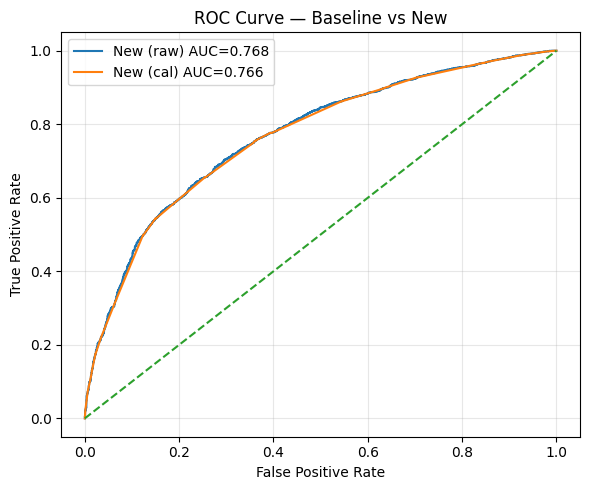

In [17]:
plt.figure(figsize=(6,5))

# New (raw)
fpr_new, tpr_new, _ = roc_curve(y_test, p_test)
auc_new = auc(fpr_new, tpr_new)
plt.plot(fpr_new, tpr_new, label=f"New (raw) AUC={auc_new:.3f}")

# New (cal)
fpr_cal, tpr_cal, _ = roc_curve(y_test, p_test_cal)
auc_cal = auc(fpr_cal, tpr_cal)
plt.plot(fpr_cal, tpr_cal, label=f"New (cal) AUC={auc_cal:.3f}")

# Baseline (if available)
if "p_test_base" in globals():
    fpr_b, tpr_b, _ = roc_curve(y_test, p_test_base)
    auc_b = auc(fpr_b, tpr_b)
    plt.plot(fpr_b, tpr_b, label=f"Baseline AUC={auc_b:.3f}")

# Diagonal
plt.plot([0,1],[0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Baseline vs New")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

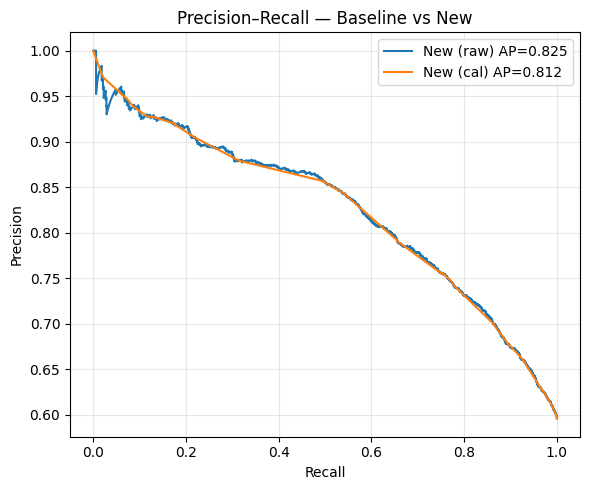

In [18]:
plt.figure(figsize=(6,5))

# New (raw)
prec_n, rec_n, _ = precision_recall_curve(y_test, p_test)
ap_n = average_precision_score(y_test, p_test)
plt.plot(rec_n, prec_n, label=f"New (raw) AP={ap_n:.3f}")

# New (cal)
prec_c, rec_c, _ = precision_recall_curve(y_test, p_test_cal)
ap_c = average_precision_score(y_test, p_test_cal)
plt.plot(rec_c, prec_c, label=f"New (cal) AP={ap_c:.3f}")

# Baseline (if available)
if "p_test_base" in globals():
    prec_b, rec_b, _ = precision_recall_curve(y_test, p_test_base)
    ap_b = average_precision_score(y_test, p_test_base)
    plt.plot(rec_b, prec_b, label=f"Baseline AP={ap_b:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall — Baseline vs New")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

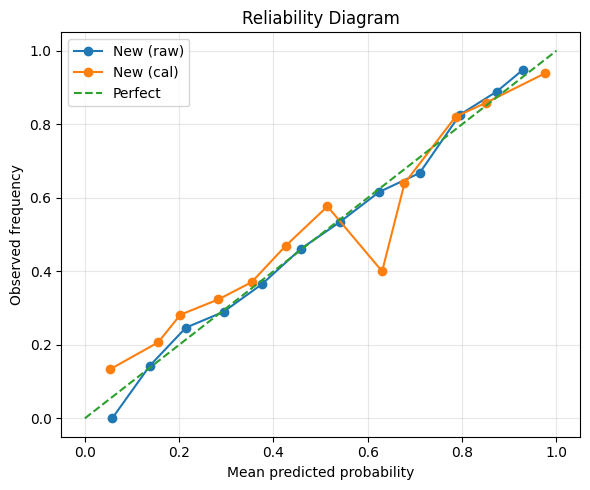

In [19]:
def plot_cal_curve(y, p, label):
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=12, strategy="uniform")
    plt.plot(mean_pred, frac_pos, marker="o", label=label)

plt.figure(figsize=(6,5))
plot_cal_curve(y_test, p_test, "New (raw)")
plot_cal_curve(y_test, p_test_cal, "New (cal)")
if "p_test_base" in globals():
    plot_cal_curve(y_test, p_test_base, "Baseline")

# Perfect calibration line
xs = np.linspace(0,1,100)
plt.plot(xs, xs, linestyle="--", label="Perfect")

plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

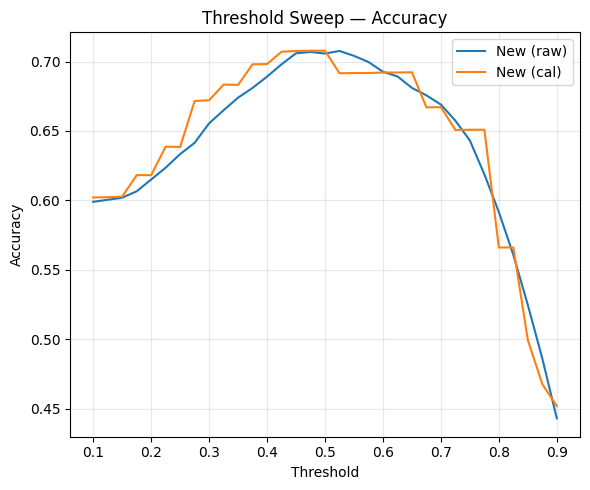

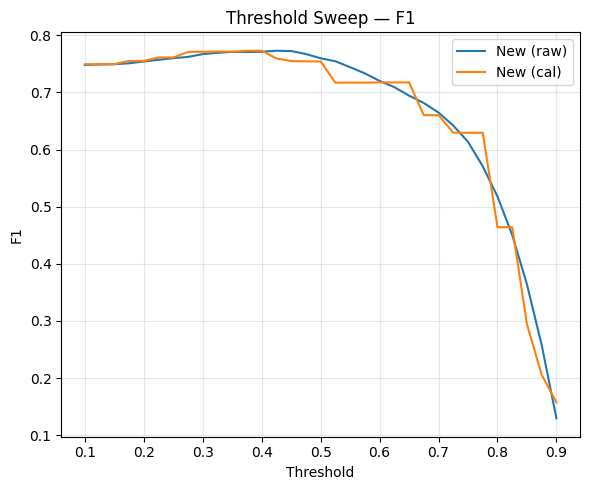

In [20]:
def sweep_metrics(y, p, label):
    thrs = np.linspace(0.1, 0.9, 33)
    accs = []
    f1s  = []
    for t in thrs:
        yhat = (p >= t).astype(int)
        accs.append(accuracy_score(y, yhat))
        f1s.append(f1_score(y, yhat))
    return thrs, np.array(accs), np.array(f1s), label

# Accuracy
plt.figure(figsize=(6,5))
th, acc_new, f1_new, lab_n = sweep_metrics(y_test, p_test, "New (raw)")
plt.plot(th, acc_new, label="New (raw)")
th, acc_cal, f1_cal, lab_c = sweep_metrics(y_test, p_test_cal, "New (cal)")
plt.plot(th, acc_cal, label="New (cal)")
if "p_test_base" in globals():
    th, acc_b, f1_b, lab_b = sweep_metrics(y_test, p_test_base, "Baseline")
    plt.plot(th, acc_b, label="Baseline")

plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Threshold Sweep — Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# F1
plt.figure(figsize=(6,5))
plt.plot(th, f1_new, label="New (raw)")
plt.plot(th, f1_cal, label="New (cal)")
if "p_test_base" in globals():
    plt.plot(th, f1_b, label="Baseline")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold Sweep — F1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

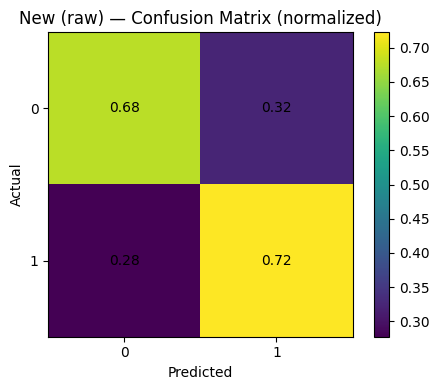

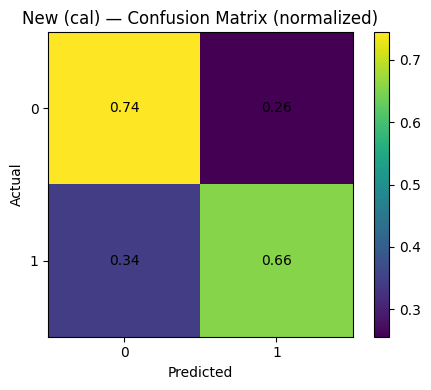

In [21]:
thr = 0.55  # you used ~0.55 earlier; change if needed

def plot_cm(y, p, title):
    yhat = (p >= thr).astype(int)
    cm = confusion_matrix(y, yhat)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(5,4))
    plt.imshow(cmn, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cmn):
        plt.text(j, i, f"{v:.2f}", ha="center", va="center")
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    plt.colorbar()
    plt.tight_layout()

plot_cm(y_test, p_test, "New (raw) — Confusion Matrix (normalized)")
plot_cm(y_test, p_test_cal, "New (cal) — Confusion Matrix (normalized)")
if "p_test_base" in globals():
    plot_cm(y_test, p_test_base, "Baseline — Confusion Matrix (normalized)")

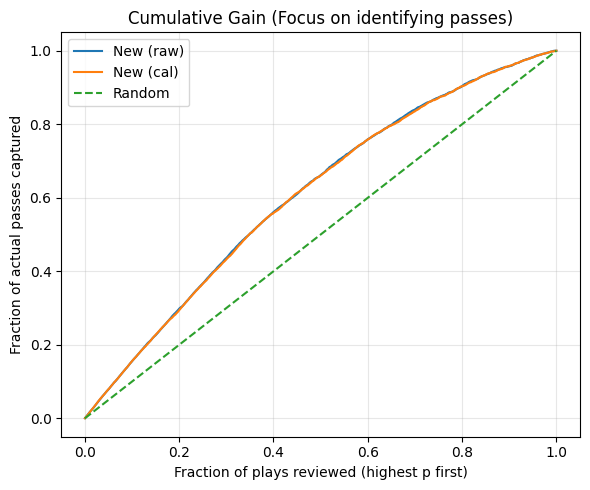

In [22]:
def cumulative_gain(y_true, p_scores, label):
    # sort by predicted prob desc
    order = np.argsort(-p_scores)
    y_sorted = np.array(y_true)[order]
    cum_pos = np.cumsum(y_sorted)
    total_pos = y_sorted.sum()
    frac_samples = np.arange(1, len(y_sorted)+1) / len(y_sorted)
    gain = cum_pos / max(total_pos, 1)
    return frac_samples, gain, label

plt.figure(figsize=(6,5))
x, g_new, _ = cumulative_gain(y_test, p_test, "New (raw)")
plt.plot(x, g_new, label="New (raw)")
x, g_cal, _ = cumulative_gain(y_test, p_test_cal, "New (cal)")
plt.plot(x, g_cal, label="New (cal)")

if "p_test_base" in globals():
    x, g_base, _ = cumulative_gain(y_test, p_test_base, "Baseline")
    plt.plot(x, g_base, label="Baseline")

# Random model line
plt.plot([0,1],[0,1], linestyle="--", label="Random")

plt.xlabel("Fraction of plays reviewed (highest p first)")
plt.ylabel("Fraction of actual passes captured")
plt.title("Cumulative Gain (Focus on identifying passes)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

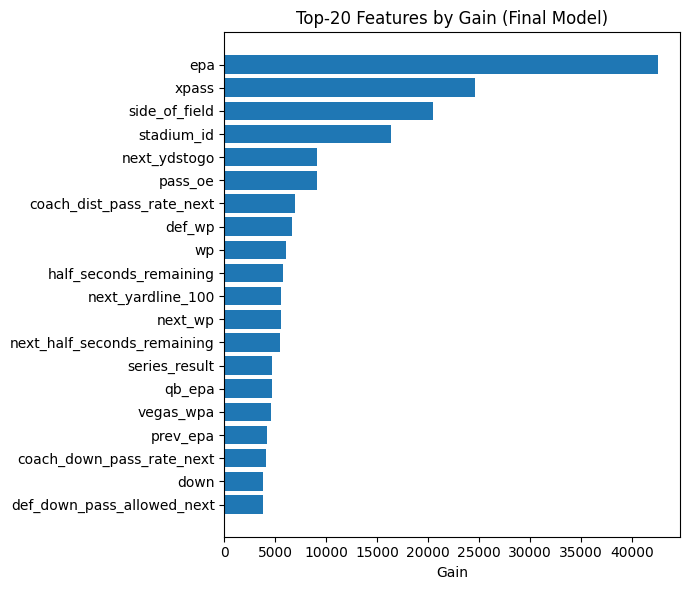

In [23]:
booster = final_clf.booster_
imp = pd.DataFrame({
    "feature": booster.feature_name(),
    "gain": booster.feature_importance(importance_type="gain"),
    "split": booster.feature_importance(importance_type="split"),
})
imp = imp.sort_values("gain", ascending=False).head(20)

plt.figure(figsize=(7,6))
plt.barh(imp["feature"][::-1], imp["gain"][::-1])
plt.title("Top-20 Features by Gain (Final Model)")
plt.xlabel("Gain")
plt.tight_layout()

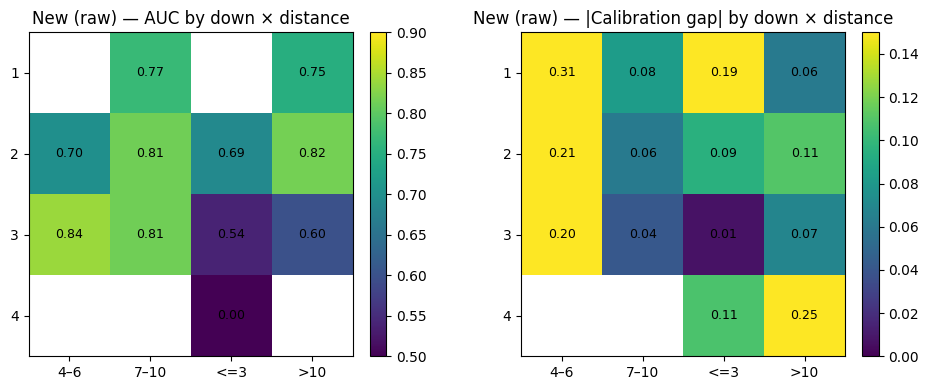

In [24]:
# Build eval frame
eval_df = pd.DataFrame({"y": y_test.values, "p": p_test})
if "p_test_cal" in globals():   eval_df["p_cal"]  = p_test_cal
if "p_test_base" in globals():  eval_df["p_base"] = p_test_base

# Pull situation features from X_test_raw
yds = (X_test_raw["next_ydstogo"]
       if "next_ydstogo" in X_test_raw.columns
       else X_test_raw.filter(like="ydstogo").iloc[:, 0])
down = (X_test_raw["next_down"]
        if "next_down" in X_test_raw.columns
        else X_test_raw.filter(regex=r"(^|_)down(_|$)").iloc[:, 0])

eval_df["down"] = pd.to_numeric(down, errors="coerce")
eval_df["dist"] = pd.cut(
    yds, bins=[-np.inf, 3, 6, 10, np.inf],
    labels=["<=3", "4–6", "7–10", ">10"]
).astype(str)

def group_metrics(df, prob_col):
    rows = []
    for (d, dist), g in df.groupby(["down", "dist"], dropna=True):
        y, p = g["y"].values, g[prob_col].values
        auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else np.nan
        gap = float(abs(p.mean() - y.mean()))  # mean pred vs empirical rate
        rows.append({"down": d, "dist": dist, "n": len(g), "auc": auc, "abs_gap": gap})
    m = pd.DataFrame(rows)
    m = m.sort_values(["down", "dist"])
    return m

models = {"New (raw)": "p"}
if "p_test_cal"  in eval_df.columns: models["New (cal)"]  = "p_cal"
if "p_test_base" in eval_df.columns: models["Baseline"]   = "p_base"

for name, col in models.items():
    M = group_metrics(eval_df, col)
    auc_p  = M.pivot(index="down", columns="dist", values="auc")
    gap_p  = M.pivot(index="down", columns="dist", values="abs_gap")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # AUC heatmap
    im0 = axes[0].imshow(auc_p, vmin=0.50, vmax=0.90)
    axes[0].set_title(f"{name} — AUC by down × distance")
    axes[0].set_xticks(range(len(auc_p.columns))); axes[0].set_xticklabels(auc_p.columns)
    axes[0].set_yticks(range(len(auc_p.index)));   axes[0].set_yticklabels(auc_p.index.astype(int))
    for i in range(auc_p.shape[0]):
        for j in range(auc_p.shape[1]):
            val = auc_p.iloc[i, j]
            if pd.notnull(val):
                axes[0].text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Calibration gap heatmap
    im1 = axes[1].imshow(gap_p, vmin=0.00, vmax=0.15)
    axes[1].set_title(f"{name} — |Calibration gap| by down × distance")
    axes[1].set_xticks(range(len(gap_p.columns))); axes[1].set_xticklabels(gap_p.columns)
    axes[1].set_yticks(range(len(gap_p.index)));   axes[1].set_yticklabels(gap_p.index.astype(int))
    for i in range(gap_p.shape[0]):
        for j in range(gap_p.shape[1]):
            val = gap_p.iloc[i, j]
            if pd.notnull(val):
                axes[1].text(j, i, f"{val:.02f}", ha="center", va="center", fontsize=9)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()